In [114]:
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()
print(help(SmilesEnumerator))

Help on class SmilesEnumerator in module SmilesEnumerator:

class SmilesEnumerator(builtins.object)
 |  SmilesEnumerator(charset='@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False)
 |
 |  SMILES Enumerator, vectorizer and devectorizer
 |
 |  #Arguments
 |      charset: string containing the characters for the vectorization
 |        can also be generated via the .fit() method
 |      pad: Length of the vectorization
 |      leftpad: Add spaces to the left of the SMILES
 |      isomericSmiles: Generate SMILES containing information about stereogenic centers
 |      enum: Enumerate the SMILES during transform
 |      canonical: use canonical SMILES during transform (overrides enum)
 |
 |  Methods defined here:
 |
 |  __init__(self, charset='@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  fit(self, smiles, extra_chars=[], extr

In [115]:
for i in range(10):
    print(sme.randomize_smiles("CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2"))

C[NH+]1C[C@@H](CC=C)[C@@](OC(CC)=O)(c2ccccc2)CC1
C(C)C(O[C@@]1(c2ccccc2)[C@H](CC=C)C[NH+](C)CC1)=O
O(C(=O)CC)[C@]1(c2ccccc2)CC[NH+](C)C[C@H]1CC=C
C1[NH+](C)CC[C@](OC(=O)CC)(c2ccccc2)[C@@H]1CC=C
C1[C@@](c2ccccc2)(OC(CC)=O)[C@H](CC=C)C[NH+](C)C1
c1c([C@@]2(OC(CC)=O)CC[NH+](C)C[C@H]2CC=C)cccc1
c1([C@]2(OC(=O)CC)[C@H](CC=C)C[NH+](C)CC2)ccccc1
C1C[NH+](C)C[C@@H](CC=C)[C@]1(c1ccccc1)OC(=O)CC
C1[NH+](C)CC[C@](OC(CC)=O)(c2ccccc2)[C@@H]1CC=C
C1C[C@](OC(CC)=O)(c2ccccc2)[C@H](CC=C)C[NH+]1C


In [116]:
import numpy as np
smiles = np.array(["CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2"])
print(smiles.shape)

(1,)


In [117]:
sme.fit(smiles)
print(sme.charset)
print(sme.pad)

=(Oc+]2CH1@N)[
50


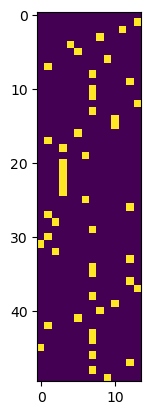

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
vect = sme.transform(smiles)
plt.imshow(vect[0])

True False


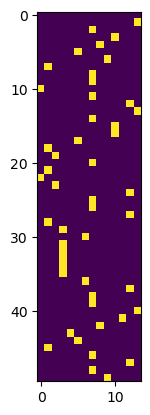

In [119]:
print(sme.enumerate, sme.canonical)
vect = sme.transform(smiles)
plt.imshow(vect[0])

In [120]:
print(sme.reverse_transform(vect))

['[C@H]1(CC=C)[C@@](OC(=O)CC)(c2ccccc2)CC[NH+](C)C1']


In [142]:
import os
import pandas as pd
# file_path = './data/train.csv'
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

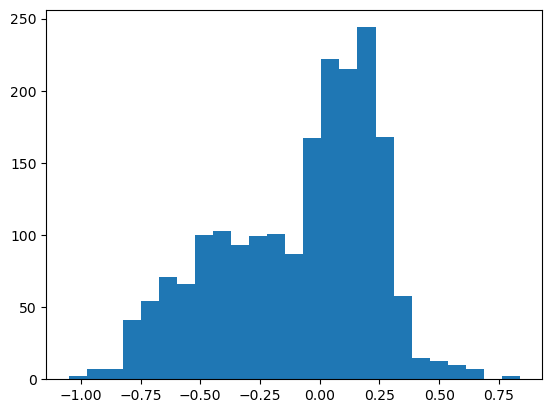

In [143]:
from sklearn.model_selection import train_test_split

#We ignore the > signs, and use random splitting for simplicity
# X_train,  X_test, y_train, y_test = train_test_split(df['Smiles'],
#                                                     df['pIC50'].values.reshape(-1,1),
#                                                     random_state=42)

X_train, y_train = df['Smiles'], df['pIC50'].values.reshape(-1,1)
X_test = df_test['Smiles']

from sklearn.preprocessing import RobustScaler
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train = rbs.fit_transform((y_train))
y_test = rbs.transform(y_test)
_ = plt.hist(y_train, bins=25)

In [144]:
import tensorflow.keras.backend as K
from SmilesEnumerator import SmilesIterator
#The SmilesEnumerator must be fit to the entire dataset, so that all chars are registered
sme.fit(df["Smiles"], extra_chars=["9"])
sme.leftpad = True
print(sme.charset)
print(sme.pad)
#The dtype is set for the K.floatx(), which is the numerical type configured for Tensorflow or Theano
generator = SmilesIterator(X_train, y_train, sme, batch_size=200, dtype=K.floatx())

B3]1l79(/F-.oS8H6N[5r=+2#)cO\sCP@4n
150


In [145]:
X,y = generator.next()
print(X.shape)
print(y.shape)

(200, 150, 35)
(200, 1)


In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

In [147]:
# model.compile(loss="mse", optimizer=RMSprop(lr=0.005))


In [148]:
input_shape = X.shape[1:]
output_shape = 1

model = Sequential()
model.add(LSTM(64,
               input_shape=input_shape,
               dropout = 0.19
               #unroll= True
              ))
model.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.005))
print(model.summary())

/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,665 (100.25 KB)

 Trainable params: 25,665 (100.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [149]:
def custom_generator(generator):
    while True:
        inputs, targets = next(generator)
        #print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        yield inputs, targets

In [150]:
model.fit(custom_generator(generator), 
          steps_per_epoch=100, 
          epochs=25)


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 0.1465
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.1126
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 0.1046
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.1086
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 0.1160
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.1059
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.1027
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.1006
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0999
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0970
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.0978
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0950
Epoch 13/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0917
Epoch 14/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.0911
Epoch 15/25
100

In [ ]:
y_pred_test = model.predict(sme.transform(X_test))